## WUSTL EHMS 2020 Dataset Link from https://www.cse.wustl.edu/~jain/ehms/index.html
https://www.cse.wustl.edu/~jain/ehms/ftp/wustl-ehms-2020_with_attacks_categories.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tqdm import tqdm

## DATA PREPROCESSING
Below is where we will read our data and then remove all non-numeric variables. We hard code the top 10/5 variables we used LDA and Random Forests to find below. 


In [2]:
dataPath = "data.csv"
data = pd.read_csv(dataPath)


label_column = 'Label' 
data_features = data.drop(columns=[label_column]).select_dtypes(include=['float64', 'int64'])
Labels = data[label_column]
# Add this to see excluded columns
excluded_columns = set(data.columns) - set(data_features.columns)
print("Excluded columns (including label):", excluded_columns)

# Standardize
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_features)

# feature lists
top_10_features_list_RF = ['DIntPkt', 'Load', 'DstJitter', 'Dur', 'SrcLoad', 
                           'Rate', 'Packet_num', 'SIntPkt', 'DstLoad', 'SrcJitter']
top_10_features_rf = pd.DataFrame(data_features, columns=top_10_features_list_RF)
top_5_features_rf = pd.DataFrame(data_features, columns=top_10_features_list_RF[:5])

top_10_features_list_LDA = ['pLoss', 'pDstLoss', 'Loss', 'SIntPktAct', 'pSrcLoss', 
                            'SrcJitter', 'DstBytes', 'DstJitter', 'Rate', 'SrcBytes']
top_10_features_LDA = pd.DataFrame(data_features, columns=top_10_features_list_LDA)
top_5_features_LDA = pd.DataFrame(data_features, columns=top_10_features_list_LDA[:5])

print("Top 10 features (Random Forest):")
print(top_10_features_rf.columns.tolist())

print("\nTop 5 features (Random Forest):")
print(top_5_features_rf.columns.tolist())

print("\nTop 10 features (LDA):")
print(top_10_features_LDA.columns.tolist())

print("\nTop 5 features (LDA):")
print(top_5_features_LDA.columns.tolist())

print("\nAll features:")
print(data_features.columns.tolist())

Excluded columns (including label): {'Attack Category', 'Label', 'DstAddr', 'SrcAddr', 'SrcMac', 'Dir', 'Sport', 'Flgs', 'DstMac'}
Top 10 features (Random Forest):
['DIntPkt', 'Load', 'DstJitter', 'Dur', 'SrcLoad', 'Rate', 'Packet_num', 'SIntPkt', 'DstLoad', 'SrcJitter']

Top 5 features (Random Forest):
['DIntPkt', 'Load', 'DstJitter', 'Dur', 'SrcLoad']

Top 10 features (LDA):
['pLoss', 'pDstLoss', 'Loss', 'SIntPktAct', 'pSrcLoss', 'SrcJitter', 'DstBytes', 'DstJitter', 'Rate', 'SrcBytes']

Top 5 features (LDA):
['pLoss', 'pDstLoss', 'Loss', 'SIntPktAct', 'pSrcLoss']

All features:
['Dport', 'SrcBytes', 'DstBytes', 'SrcLoad', 'DstLoad', 'SrcGap', 'DstGap', 'SIntPkt', 'DIntPkt', 'SIntPktAct', 'DIntPktAct', 'SrcJitter', 'DstJitter', 'sMaxPktSz', 'dMaxPktSz', 'sMinPktSz', 'dMinPktSz', 'Dur', 'Trans', 'TotPkts', 'TotBytes', 'Load', 'Loss', 'pLoss', 'pSrcLoss', 'pDstLoss', 'Rate', 'Packet_num', 'Temp', 'SpO2', 'Pulse_Rate', 'SYS', 'DIA', 'Heart_rate', 'Resp_Rate', 'ST']


## Helper Functions

print_classification_results is used to display model results. 


In [3]:
def print_classification_results(confusion_matrix, classification_report, accuracy):
    #prints the cm results, classification report, and accuracy
    tn, fp, fn, tp = confusion_matrix.ravel()
    total = tn + fp + fn + tp
    
    # Calculate percentages
    tn_pct = (tn/total) * 100
    fp_pct = (fp/total) * 100
    fn_pct = (fn/total) * 100
    tp_pct = (tp/total) * 100
    
    # Print confusion matrix results
    print("\nConfusion Matrix Results:")
    print(f"""
    True Negatives: {tn} ({tn_pct:.2f}%)
    False Positives: {fp} ({fp_pct:.2f}%)
    False Negatives: {fn} ({fn_pct:.2f}%)
    True Positives: {tp} ({tp_pct:.2f}%)
    """)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report)
    
    # Print accuracy
    print(f"\nModel Accuracy: {accuracy:.2%}")


## Model Functions

Below are functions for K-Means, LDA, Random Forest, SVM, Gaussian Naive Bayes, and CNN. All functions take the data, feature names we want to use, and correct labels. When all the numeric features are used (36 total), then we will save an image of the ROC curve. 

In [4]:


def perform_kmeans_clustering(data_scaled, features, labels, n_components=2):

    print("\nPerforming K-means on this many features: ", len(features.columns))
    
    scaled_df = pd.DataFrame(data_scaled, columns=features.columns)
    
    #  only the specified features
    selected_features = scaled_df[features.columns]
    
    # pca to reduce dimensionality
    pca = PCA(n_components=n_components)
    pc_features = pca.fit_transform(selected_features)
    
    pca_df = pd.DataFrame(
        data=pc_features,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        pca_df, labels, test_size=0.3, random_state=42
    )
    

    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(X_train)
    y_pred = kmeans.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)    
    accuracy = accuracy_score(y_test, y_pred)
    
    # only save if using all features
    if len(features.columns) == 36:
        print("\nClassification Report of k means:")
        print(class_report)
    
    return cm, class_report, accuracy

In [5]:


def train_random_forest(data_scaled, Labels, features, n_estimators):
  
    print(f"Training Random Forest with {n_estimators} estimators")
    print(f"Number of features used: {len(features.columns)}")
    
    scaled_df = pd.DataFrame(data_scaled, columns=features.columns)
    
    #  only specified features
    selected_features = scaled_df[features.columns]
    
    # split
    X_train, X_test, y_train, y_test = train_test_split(
        selected_features, Labels, test_size=0.3, random_state=42
    )

    # Train
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # feature importance for selecting best features
    feature_importance = pd.DataFrame({
        'feature': features.columns,
        'importance': rf_classifier.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))
    
    # Save curve if the number of features is 36
    if len(features.columns) == 36:
        print("\nClassification Report of random forest:")
        print(class_report)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Random Forest with 36 Features')
        plt.legend(loc='lower right')
        plt.savefig('roc_curve_rf_36_features.png')
        # plt.show()
        
    
    return cm, class_report, accuracy

In [6]:


def perform_lda(data_scaled, labels, features, top_n=10):

    print(f"\nPerforming LDA on {len(features.columns)} features")
    
    scaled_df = pd.DataFrame(data_scaled, columns=features.columns)
    
    # only specified features
    selected_features = scaled_df[features.columns].values
    
    # Split using the features DataFrame
    X_train, X_test, y_train, y_test = train_test_split(
        selected_features, labels, test_size=0.3, random_state=42
    )

    lda = LDA()
    lda.fit(X_train, y_train)
    
    # Print component coefficients
    print("\nLinear Discriminant Coefficients:")
    for i, component in enumerate(lda.coef_):
        print(f"\nLD{i+1} coefficients:")
        for feat, coef in zip(features.columns, component):
            print(f"{feat}: {coef:.4f}")

    # predict
    y_pred = lda.predict(X_test)
    y_pred_proba = lda.predict_proba(X_test)[:, 1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Save if the number of features is 36
    if len(features.columns) == 36:
        print("\nClassification Report of LDA:")
        print(class_report)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for LDA with 36 Features')
        plt.legend(loc='lower right')
        plt.savefig('roc_curve_lda_36_features.png')
        
    
    # Find top n important features if requested
    top_features = None
    if top_n:
        # Sum coefficients across all discriminant functions - had chat gpt help
        feature_importance = pd.Series(np.sum(np.abs(lda.coef_), axis=0), index=features.columns)
        top_features = feature_importance.nlargest(top_n)
        print(f"\nTop {top_n} most important features:")
        print(top_features)
    
    return conf_matrix, class_report, accuracy, top_features

In [7]:


def gaussian_naive_bayes(data_scaled, labels, features):
    print(f"\nPerforming Gaussian Naive Bayes on {len(features.columns)} features")
    
    scaled_df = pd.DataFrame(data_scaled, columns=features.columns)
    selected_features = scaled_df[features.columns]
    
    # Split 
    X_train, X_test, y_train, y_test = train_test_split(
        selected_features, labels, test_size=0.3, random_state=42
    )
    
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    y_pred_proba = gnb.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Save if the number of features is 36
    if len(features.columns) == 36:
        print("\nClassification Report of GNB:")
        print(class_report)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Gaussian Naive Bayes with 36 Features')
        plt.legend(loc='lower right')
        plt.savefig('roc_curve_gnb_36_features.png')
        # plt.show()
    
    return cm, class_report, accuracy

In [8]:


def train_SVC(data_scaled, features, labels):
    
    print("\nPerforming SVC on this many features: ", len(features.columns))
    
    scaled_df = pd.DataFrame(data_scaled, columns=features.columns)
    selected_features = scaled_df[features.columns]
    X_train, X_test, y_train, y_test = train_test_split(
        selected_features, labels, test_size=0.3, random_state=42
    )

    kernelTypes = ['linear', 'rbf', 'poly']
    best_accuracy = 0
    best_metrics = None
    
    print("\nTraining SVC models with different kernels...")
    for kernelType in tqdm(kernelTypes, desc='Training'):
        model = SVC(kernel=kernelType, C=1, probability=True)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
  
        report = classification_report(y_test, y_pred)
        print(f"\nClassification Report of SVC of {kernelType}:")
        print(report)
        
        print(f"\nKernel: {kernelType}")
        print(f"Accuracy: {accuracy:.5f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_metrics = (cm, report, accuracy)
            best_model = model
    
    # Save if the number of features is 36
    if len(features.columns) == 36:
      
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for SVC with 36 Features')
        plt.legend(loc='lower right')
        plt.savefig('roc_curve_svc_36_features.png')
        # plt.show()
    
    return best_metrics

In [9]:
def CNN(data_scaled, labels, features):
  
    print(f"\nPerforming CNN on {len(features.columns)} features")
    
    # Data preparation (keep existing code until reshape)
    scaled_df = pd.DataFrame(data_scaled, columns=features.columns)
    selected_features = scaled_df[features.columns].values
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(labels)
    y_categorical = to_categorical(y_encoded)

    # reshape to input data, need to work with either 10 or 36 features
    num_features = selected_features.shape[1]
    grid_size = int(np.ceil(np.sqrt(num_features)))
    X_padded = np.zeros((selected_features.shape[0], grid_size * grid_size))
    X_padded[:, :num_features] = selected_features
    X_reshaped = X_padded.reshape(-1, grid_size, grid_size, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X_reshaped, y_categorical, test_size=0.3, random_state=42
    )

    model = Sequential()
    
    # had Chat GPT help here to change grid size based on how the data looks 
    #the issue popped up when I inputted top 5 or top 10 features rather than using 36
    if grid_size < 5:
        model.add(Conv2D(32, kernel_size=(2,2), activation='relu', 
                        input_shape=(grid_size, grid_size, 1),
                        padding='same'))
    else:
        model.add(Conv2D(32, kernel_size=(3,3), activation='relu', 
                        input_shape=(grid_size, grid_size, 1),
                        padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        
        # Add second conv layer only for larger inputs
        if grid_size >= 7:
            model.add(Conv2D(64, kernel_size=(2,2), activation='relu', padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))  # Reduced dense layer size
    model.add(Dropout(0.3))  # Reduced dropout
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, 
                       validation_data=(X_test, y_test), verbose=0)

    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    accuracy = accuracy_score(y_test_labels, y_pred)
    

    if num_features == 36:
        print("\nClassification Report of CNN:")
        print(class_report)
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for CNN with 36 Features')
        plt.legend(loc='lower right')
        plt.savefig('roc_curve_cnn_36_features.png')
        # plt.show()
    
    return cm, class_report, accuracy

## Final Function

The code block below will run each model with each of the five different feature sets specified. 


Performing LDA on 36 features

Linear Discriminant Coefficients:

LD1 coefficients:
Dport: 0.0000
SrcBytes: 4.5746
DstBytes: -9.3746
SrcLoad: -0.4146
DstLoad: -3.5580
SrcGap: -0.0000
DstGap: 0.0000
SIntPkt: -2.3615
DIntPkt: -0.4477
SIntPktAct: 453.4666
DIntPktAct: -0.0000
SrcJitter: -153.6353
DstJitter: 7.8913
sMaxPktSz: 0.0185
dMaxPktSz: -0.9048
sMinPktSz: -0.7674
dMinPktSz: 0.0000
Dur: 2.0393
Trans: 0.0000
TotPkts: 2.6564
TotBytes: -1.0525
Load: -2.3268
Loss: -552.0637
pLoss: 1173.2676
pSrcLoss: -384.6796
pDstLoss: -600.8920
Rate: 4.7021
Packet_num: -0.0375
Temp: -0.0457
SpO2: 0.0027
Pulse_Rate: 0.2497
SYS: -0.0287
DIA: 0.1639
Heart_rate: 0.0998
Resp_Rate: 0.0286
ST: 0.2382

Classification Report of LDA:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4252
           1       0.94      0.45      0.61       644

    accuracy                           0.92      4896
   macro avg       0.93      0.73      0.79      4896
weighted av

Training:  33%|███▎      | 1/3 [00:35<01:11, 35.53s/it]


Classification Report of SVC of linear:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4252
           1       0.94      0.47      0.62       644

    accuracy                           0.93      4896
   macro avg       0.93      0.73      0.79      4896
weighted avg       0.93      0.93      0.91      4896


Kernel: linear
Accuracy: 0.92586


Training:  67%|██████▋   | 2/3 [00:52<00:24, 24.62s/it]


Classification Report of SVC of rbf:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4252
           1       0.99      0.47      0.64       644

    accuracy                           0.93      4896
   macro avg       0.96      0.73      0.80      4896
weighted avg       0.93      0.93      0.92      4896


Kernel: rbf
Accuracy: 0.92933


Training: 100%|██████████| 3/3 [01:04<00:00, 21.43s/it]


Classification Report of SVC of poly:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4252
           1       0.97      0.47      0.63       644

    accuracy                           0.93      4896
   macro avg       0.95      0.73      0.80      4896
weighted avg       0.93      0.93      0.92      4896


Kernel: poly
Accuracy: 0.92851



Performing Gaussian Naive Bayes on 36 features

Classification Report of GNB:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4252
           1       0.43      0.48      0.45       644

    accuracy                           0.85      4896
   macro avg       0.67      0.69      0.68      4896
weighted avg       0.85      0.85      0.85      4896


Performing CNN on 36 features


c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Classification Report of CNN:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4252
           1       0.96      0.51      0.67       644

    accuracy                           0.93      4896
   macro avg       0.95      0.75      0.82      4896
weighted avg       0.93      0.93      0.92      4896


Performing LDA on 5 features

Linear Discriminant Coefficients:

LD1 coefficients:
pLoss: 3.4085
pDstLoss: -2.2251
Loss: -0.3130
SIntPktAct: 0.4211
pSrcLoss: -1.6207

Top 10 most important features:
pLoss         3.408538
pDstLoss      2.225052
pSrcLoss      1.620706
SIntPktAct    0.421074
Loss          0.313039
dtype: float64
Training Random Forest with 100 estimators
Number of features used: 5


c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Top 10 Most Important Features:
      feature  importance
1    pDstLoss    0.326323
0       pLoss    0.310721
2        Loss    0.258536
4    pSrcLoss    0.088448
3  SIntPktAct    0.015973

Performing K-means on this many features:  5

Performing SVC on this many features:  5

Training SVC models with different kernels...


Training:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to


Classification Report of SVC of linear:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4252
           1       0.00      0.00      0.00       644

    accuracy                           0.87      4896
   macro avg       0.43      0.50      0.46      4896
weighted avg       0.75      0.87      0.81      4896


Kernel: linear
Accuracy: 0.86846


c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Classification Report of SVC of rbf:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4252
           1       0.00      0.00      0.00       644

    accuracy                           0.87      4896
   macro avg       0.43      0.50      0.46      4896
weighted avg       0.75      0.87      0.81      4896


Kernel: rbf
Accuracy: 0.86846


c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Classification Report of SVC of poly:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4252
           1       0.00      0.00      0.00       644

    accuracy                           0.87      4896
   macro avg       0.43      0.50      0.46      4896
weighted avg       0.75      0.87      0.81      4896


Kernel: poly
Accuracy: 0.86846

Performing Gaussian Naive Bayes on 5 features

Performing CNN on 5 features


c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Performing LDA on 10 features

Linear Discriminant Coefficients:

LD1 coefficients:
pLoss: 393.8038
pDstLoss: -201.8607
Loss: -185.6725
SIntPktAct: 153.4113
pSrcLoss: -129.0672
SrcJitter: -52.4839
DstBytes: -1.7181
DstJitter: 2.5665
Rate: -1.5558
SrcBytes: 1.2818

Top 10 most important features:
pLoss         393.803799
pDstLoss      201.860726
Loss          185.672451
SIntPktAct    153.411333
pSrcLoss      129.067201
SrcJitter      52.483944
DstJitter       2.566473
DstBytes        1.718067
Rate            1.555772
SrcBytes        1.281833
dtype: float64
Training Random Forest with 100 estimators
Number of features used: 10

Top 10 Most Important Features:
      feature  importance
7   DstJitter    0.440178
8        Rate    0.337131
5   SrcJitter    0.208638
6    DstBytes    0.006746
9    SrcBytes    0.006033
0       pLoss    0.000368
4    pSrcLoss    0.000365
2        Loss    0.000298
1    pDstLoss    0.000195
3  SIntPktAct    0.000049

Performing K-means on this many features:  10


Training:  33%|███▎      | 1/3 [00:09<00:18,  9.43s/it]


Classification Report of SVC of linear:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4252
           1       0.95      0.47      0.63       644

    accuracy                           0.93      4896
   macro avg       0.94      0.73      0.79      4896
weighted avg       0.93      0.93      0.92      4896


Kernel: linear
Accuracy: 0.92688


Training:  67%|██████▋   | 2/3 [00:20<00:10, 10.57s/it]


Classification Report of SVC of rbf:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4252
           1       0.99      0.47      0.63       644

    accuracy                           0.93      4896
   macro avg       0.96      0.73      0.80      4896
weighted avg       0.93      0.93      0.92      4896


Kernel: rbf
Accuracy: 0.92892


Training: 100%|██████████| 3/3 [00:28<00:00,  9.61s/it]


Classification Report of SVC of poly:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4252
           1       0.96      0.46      0.63       644

    accuracy                           0.93      4896
   macro avg       0.94      0.73      0.79      4896
weighted avg       0.93      0.93      0.92      4896


Kernel: poly
Accuracy: 0.92729

Performing Gaussian Naive Bayes on 10 features

Performing CNN on 10 features



c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Performing LDA on 5 features

Linear Discriminant Coefficients:

LD1 coefficients:
DIntPkt: -0.6907
Load: -1.0650
DstJitter: 1.8382
Dur: -0.6179
SrcLoad: -0.2895

Top 10 most important features:
DstJitter    1.838189
Load         1.064962
DIntPkt      0.690748
Dur          0.617912
SrcLoad      0.289481
dtype: float64
Training Random Forest with 100 estimators
Number of features used: 5

Top 10 Most Important Features:
     feature  importance
0    DIntPkt    0.250659
2  DstJitter    0.249182
4    SrcLoad    0.214627
3        Dur    0.151189
1       Load    0.134344

Performing K-means on this many features:  5

Performing SVC on this many features:  5

Training SVC models with different kernels...


Training:  33%|███▎      | 1/3 [00:11<00:22, 11.32s/it]


Classification Report of SVC of linear:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4252
           1       0.94      0.47      0.62       644

    accuracy                           0.93      4896
   macro avg       0.93      0.73      0.79      4896
weighted avg       0.93      0.93      0.91      4896


Kernel: linear
Accuracy: 0.92586


Training:  67%|██████▋   | 2/3 [00:23<00:11, 11.94s/it]


Classification Report of SVC of rbf:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4252
           1       0.96      0.47      0.63       644

    accuracy                           0.93      4896
   macro avg       0.94      0.73      0.79      4896
weighted avg       0.93      0.93      0.92      4896


Kernel: rbf
Accuracy: 0.92729


Training: 100%|██████████| 3/3 [00:34<00:00, 11.54s/it]


Classification Report of SVC of poly:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4252
           1       0.98      0.47      0.63       644

    accuracy                           0.93      4896
   macro avg       0.95      0.73      0.80      4896
weighted avg       0.93      0.93      0.92      4896


Kernel: poly
Accuracy: 0.92872

Performing Gaussian Naive Bayes on 5 features

Performing CNN on 5 features



c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Performing LDA on 10 features

Linear Discriminant Coefficients:

LD1 coefficients:
DIntPkt: 0.0939
Load: -22.3502
DstJitter: 2.3100
Dur: -1.2466
SrcLoad: 0.0074
Rate: 57.9967
Packet_num: -0.1367
SIntPkt: -0.9139
DstLoad: -39.6188
SrcJitter: -0.2130

Top 10 most important features:
Rate          57.996661
DstLoad       39.618788
Load          22.350241
DstJitter      2.309951
Dur            1.246617
SIntPkt        0.913868
SrcJitter      0.213015
Packet_num     0.136689
DIntPkt        0.093929
SrcLoad        0.007363
dtype: float64
Training Random Forest with 100 estimators
Number of features used: 10


c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Top 10 Most Important Features:
      feature  importance
0     DIntPkt    0.179262
2   DstJitter    0.167164
4     SrcLoad    0.122655
6  Packet_num    0.111005
9   SrcJitter    0.078561
3         Dur    0.075984
7     SIntPkt    0.068331
5        Rate    0.068188
1        Load    0.064495
8     DstLoad    0.064356

Performing K-means on this many features:  10

Performing SVC on this many features:  10

Training SVC models with different kernels...


Training:  33%|███▎      | 1/3 [00:13<00:27, 13.67s/it]


Classification Report of SVC of linear:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      4252
           1       0.93      0.47      0.62       644

    accuracy                           0.93      4896
   macro avg       0.93      0.73      0.79      4896
weighted avg       0.93      0.93      0.91      4896


Kernel: linear
Accuracy: 0.92525


Training:  67%|██████▋   | 2/3 [00:27<00:13, 13.78s/it]


Classification Report of SVC of rbf:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4252
           1       0.97      0.46      0.62       644

    accuracy                           0.93      4896
   macro avg       0.95      0.73      0.79      4896
weighted avg       0.93      0.93      0.92      4896


Kernel: rbf
Accuracy: 0.92708


Training: 100%|██████████| 3/3 [00:36<00:00, 12.21s/it]


Classification Report of SVC of poly:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4252
           1       0.97      0.46      0.62       644

    accuracy                           0.93      4896
   macro avg       0.95      0.73      0.79      4896
weighted avg       0.93      0.93      0.92      4896


Kernel: poly
Accuracy: 0.92708

Performing Gaussian Naive Bayes on 10 features

Performing CNN on 10 features



c:\Users\allen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


                   LDA Random Forest K-Means Clustering       SVM  \
All Features  0.924428      0.933824           0.868056   0.92933   
Top 5 LDA     0.868464      0.868464           0.868056  0.868464   
Top 10 LDA    0.925858      0.919322           0.868056  0.928922   
Top 5 RF      0.910948      0.921773           0.831291  0.928717   
Top 10 RF     0.915237        0.9279           0.868464  0.927083   

             Gaussian Naive Bayes       CNN  
All Features             0.847426  0.933007  
Top 5 LDA                0.132966  0.868464  
Top 10 LDA               0.132966  0.928717  
Top 5 RF                 0.917688  0.928513  
Top 10 RF                0.866013  0.929126  


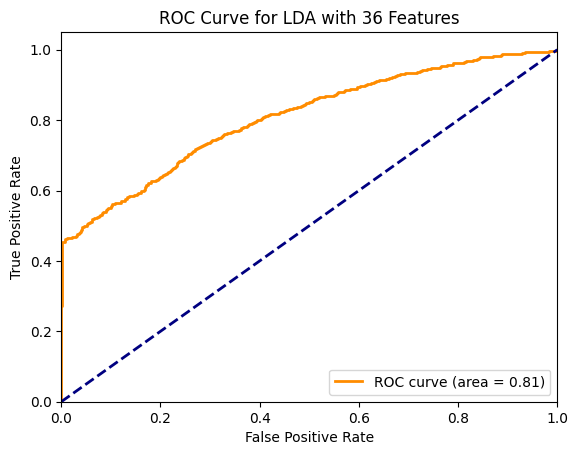

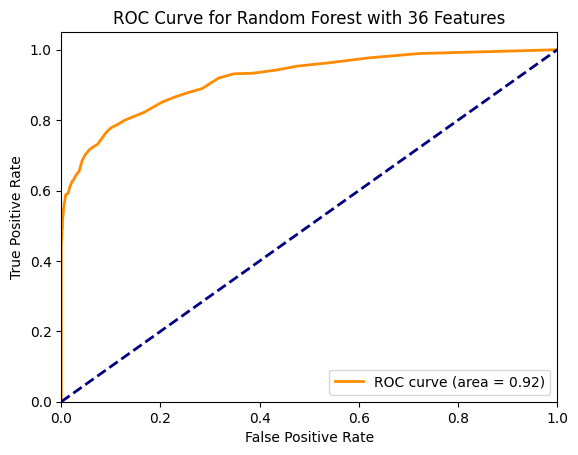

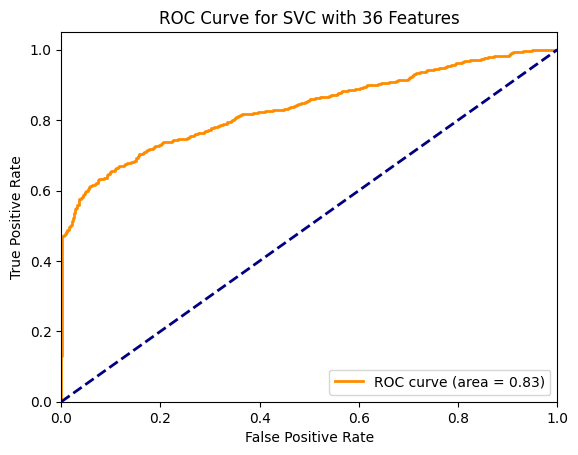

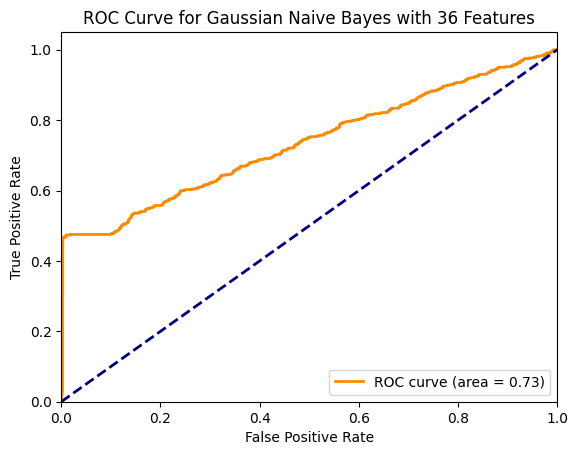

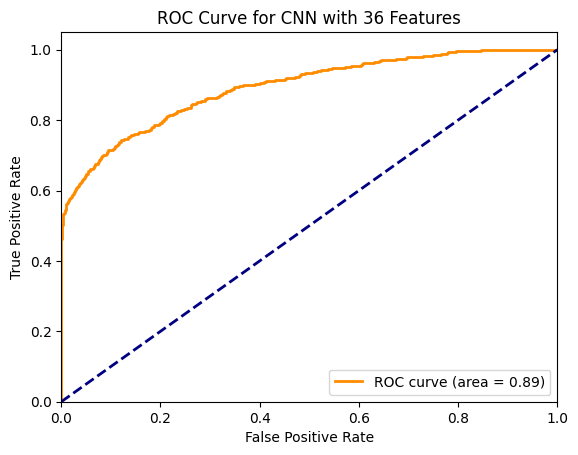

In [10]:
feature_sets = {
    'All Features': data_features,
    'Top 5 LDA': top_5_features_LDA,
    'Top 10 LDA': top_10_features_LDA,
    'Top 5 RF': top_5_features_rf,
    'Top 10 RF': top_10_features_rf
}

results_df = pd.DataFrame(index=feature_sets.keys(), columns=['LDA', 'Random Forest', 'K-Means Clustering', 'SVM', 'Gaussian Naive Bayes', 'CNN'])

# run each model with diff feature set
for feature_set_name, feature_set in feature_sets.items():
    # Select the features
    selected_features = data_features[feature_set.columns]
    selected_data_scaled = scaler.fit_transform(selected_features)
        
    # LDA
    lda_cm, lda_report, lda_accuracy, _ = perform_lda(selected_data_scaled, Labels, selected_features, top_n=10)
    results_df.loc[feature_set_name, 'LDA'] = lda_accuracy
    
    # Random Forest
    rf_cm, rf_report, rf_accuracy = train_random_forest(selected_data_scaled, Labels, selected_features, 100)
    results_df.loc[feature_set_name, 'Random Forest'] = rf_accuracy
    
    # K-Means Clustering
    km_cm, km_report, km_accuracy = perform_kmeans_clustering(selected_data_scaled, selected_features, Labels, n_components=3)
    results_df.loc[feature_set_name, 'K-Means Clustering'] = km_accuracy
    
    # SVM
    svm_cm, svm_report, svm_accuracy = train_SVC(selected_data_scaled, selected_features, Labels)
    results_df.loc[feature_set_name, 'SVM'] = svm_accuracy
    
    # Gaussian Naive Bayes
    gauss_cm, gauss_report, gauss_accuracy = gaussian_naive_bayes(selected_data_scaled, Labels, selected_features)
    results_df.loc[feature_set_name, 'Gaussian Naive Bayes'] = gauss_accuracy
    
    # CNN
    cnn_cm, cnn_report, cnn_accuracy = CNN(selected_data_scaled, Labels, selected_features)
    results_df.loc[feature_set_name, 'CNN'] = cnn_accuracy

print(results_df)